In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shapely
import os
from pathlib import Path
import osmnx as ox
from shapely import wkt
import folium
import networkx as nx
import momepy

In [4]:
place='New Haven County, Connecticut, USA'  
NH_G=ox.graph_from_place(place, network_type='drive', custom_filter='["highway"~"primary|trunk|motorway|secondary"]')

In [5]:
# Convert graph to geodataframe for easy inspection of the graph and plotting on folium
nodes_gdf=ox.graph_to_gdfs(NH_G, nodes=True, edges=False, node_geometry=True,fill_edge_geometry=False)
edges_gdf=ox.graph_to_gdfs(NH_G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


In [15]:
#check or edit projection referece
#nodes_gdf.crs
edges_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
edges_gdf.head()

osmid  \
u        v          key                                                      
69120972 318265966  0    [101975264, 101975237, 101975175, 101975147, 1...   
69120990 318266497  0    [101975236, 101975207, 101975179, 101975150, 1...   
69120996 178512410  0                                             17202219   
         69120990   0                    [101975225, 101975150, 122095871]   
69121008 2085323942 0                                            348786166   

                         oneway lanes   ref        highway maxspeed    length  \
u        v          key                                                         
69120972 318265966  0      True     2  I 95       motorway   65 mph  2248.743   
69120990 318266497  0      True     2  I 95       motorway   65 mph  2960.923   
69120996 178512410  0      True   NaN   NaN  motorway_link      NaN   450.238   
         69120990   0      True     2  I 95       motorway   65 mph   702.024   
69121008 2085323942 0      True     3  I 95       motorway   65 mph   507.769   

                        bridge  \
u        v          key          
69120972 318265966  0      yes   
69120990 318266497  0      yes   
69120996 178512410  0      NaN   
         69120990   0      yes   
69121008 2085323942 0      NaN   

                                                                  geometry  \
u        v          key                                                      
69120972 318265966  0    LINESTRING (-72.79001 41.29451, -72.79511 41.2...   
69120990 318266497  0    LINESTRING (-72.81655 41.28875, -72.81606 41.2...   
69120996 178512410  0    LINESTRING (-72.82477 41.28745, -72.82393 41.2...   
         69120990   0    LINESTRING (-72.82477 41.28745, -72.81978 41.2...   
69121008 2085323942 0    LINESTRING (-72.84377 41.28451, -72.83782 41.2...   

                        name tunnel access junction  
u        v          key                              
69120972 318265966  0    NaN    NaN    NaN      NaN  
69120990 318266497  0    NaN    NaN    NaN      NaN  
69120996 178512410  0    NaN    NaN    NaN      NaN  
         69120990   0    NaN    NaN    NaN      NaN  
69121008 2085323942 0    NaN    NaN    NaN      NaN

In [7]:
# Remove the roads where 'ref' ==NaN
edges_gdf_copy=edges_gdf[edges_gdf.ref.notna()]

In [8]:
# Recreate the graph with new edges:
G=ox.graph_from_gdfs(nodes_gdf,edges_gdf_copy, graph_attrs=None)


In [9]:
# Create new node gdf
nodes_gdf_copy=ox.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True,fill_edge_geometry=False)


In [10]:
nodes_gdf_copy.head()

y          x  street_count                    geometry  \
osmid                                                                       
69120972   41.294510 -72.790013             3  POINT (-72.79001 41.29451)   
318265966  41.289071 -72.815815             3  POINT (-72.81582 41.28907)   
69120990   41.288754 -72.816551             3  POINT (-72.81655 41.28875)   
318266497  41.293790 -72.782360             3  POINT (-72.78236 41.29379)   
69120996   41.287451 -72.824773             3  POINT (-72.82477 41.28745)   

           ref            highway  
osmid                              
69120972   NaN                NaN  
318265966   54  motorway_junction  
69120990   NaN                NaN  
318266497   55  motorway_junction  
69120996    54  motorway_junction

In [12]:
# plot and interactive map with folium:
m = ox.plot_graph_folium(G, popup_attribute="name", weight=2, color="grey")
for i in range(len(nodes_gdf_copy)):
    folium.Circle(
        location=[nodes_gdf_copy.iloc[i]['y'], nodes_gdf_copy.iloc[i]['x']],
        radius=20,
        color='blue',
        popup=nodes_gdf_copy.iloc[i].geometry
       
    ).add_to(m)
m

In [16]:
#change the projection of the graph to have 'meter' as unit
G_projection=ox.project_graph(G)


In [17]:
#consolidate intersection using osmnx 'consolidate_intersection' But its getting Stack Overflow error
ox.consolidate_intersections(G_projection, tolerance=10, rebuild_graph=True, dead_ends=False, reconnect_edges=True)

OSError: exception: stack overflow

I need to reduce the intermediate nodes withought deleting the adjacent edges:

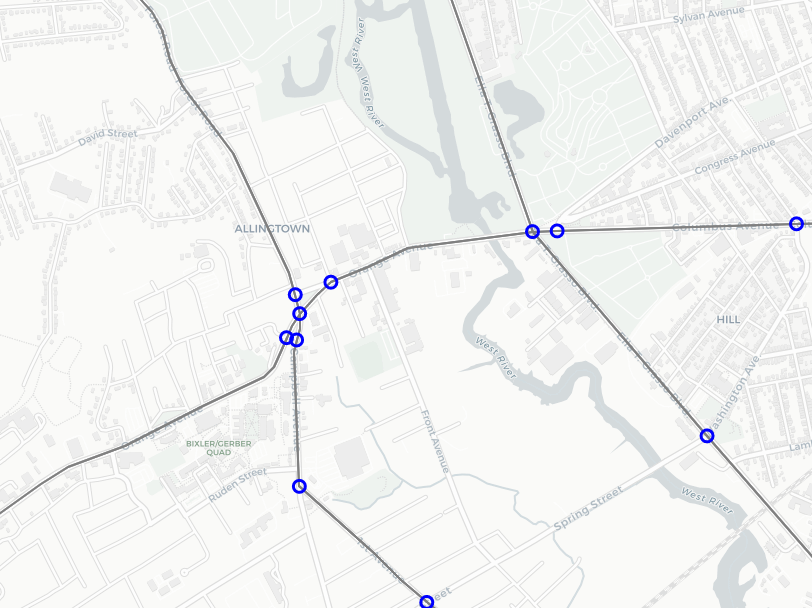